In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import dateutil.easter as easter
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


# EDA
- https://www.kaggle.com/ambrosm/tpsjan22-01-eda-which-makes-sense/notebookhttps://www.kaggle.com/ambrosm/tpsjan22-01-eda-which-makes-sense/notebook 참고하세요
- 시즌별, 요일별 배리에이션
- 이스터의 효과
- 주말 피크를 자세히 보기
- 연간 성장(연말에 더 높음)
- 왜 SMAPE로 점수를 매기나

In [2]:
train_df = pd.read_csv('../input/tabular-playground-series-jan-2022/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-jan-2022/test.csv')

for df in [train_df, test_df]:
    df['date'] = pd.to_datetime(df.date)
    df.set_index('date', inplace=True, drop=False)
    
train_df

,row_id,date,country,store,product,num_sold
date,,,,,,
2015-01-01,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
2015-01-01,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2015-01-01,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
2015-01-01,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
2015-01-01,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...,...
2018-12-31,26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
2018-12-31,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
2018-12-31,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004


# 데이터의 완결성
트레인 데이터엔 세개의 나라, 두개의 가게, 세개의 상품이있다. 
18개의 조합의 1461일의 판매 데이터가 있다.
1461일은 2015,2016, 2017, 2018 년에 포함된다.
결측값은 없다.

In [3]:
print(train_df.groupby(['country', 'store', 'product']).date.count())

print("First day:", train_df.date.min(), "  \n Last day:", train_df.date.max())
print("Number of days in four years:", 365 * 4 + 1) # 윤년이 포함됨
print(18 * 1461, train_df.shape, train_df.date.isna().sum())

country  store       product       
Finland  KaggleMart  Kaggle Hat        1461
                     Kaggle Mug        1461
                     Kaggle Sticker    1461
         KaggleRama  Kaggle Hat        1461
                     Kaggle Mug        1461
                     Kaggle Sticker    1461
Norway   KaggleMart  Kaggle Hat        1461
                     Kaggle Mug        1461
                     Kaggle Sticker    1461
         KaggleRama  Kaggle Hat        1461
                     Kaggle Mug        1461
                     Kaggle Sticker    1461
Sweden   KaggleMart  Kaggle Hat        1461
                     Kaggle Mug        1461
                     Kaggle Sticker    1461
         KaggleRama  Kaggle Hat        1461
                     Kaggle Mug        1461
                     Kaggle Sticker    1461
Name: date, dtype: int64
First day: 2015-01-01 00:00:00   
 Last day: 2018-12-31 00:00:00
Number of days in four years: 1461
26298 (26298, 6) 0


모든 제품이 모든 가게에서 모든 날에 팔렸다. 그러므로 판매량은 항상 양의 값을 가질 것이다.

In [4]:
train_df.groupby(['country', 'store', 'product']).num_sold.agg(['min', 'max', 'mean'])

min   max         mean
country store      product                               
Finland KaggleMart Kaggle Hat      210  1113   362.479808
                   Kaggle Mug      126   774   204.200548
                   Kaggle Sticker   70   326   103.044490
        KaggleRama Kaggle Hat      354  1895   628.926762
                   Kaggle Mug      220  1398   356.110883
                   Kaggle Sticker  128   559   180.232033
Norway  KaggleMart Kaggle Hat      335  1809   594.645448
                   Kaggle Mug      201  1113   334.370294
                   Kaggle Sticker  114   518   169.577687
        KaggleRama Kaggle Hat      596  2884  1036.357974
                   Kaggle Mug      366  1935   584.297741
                   Kaggle Sticker  214   874   295.607803
Sweden  KaggleMart Kaggle Hat      248  1207   419.214237
                   Kaggle Mug      149   730   235.885010
                   Kaggle Sticker   86   356   119.613279
        KaggleRama Kaggle Hat      428  2169   731.452430
                   Kaggle Mug      253  1438   411.273101
                   Kaggle Sticker  148   637   208.314853

학습 데이터는 2015년부터 2018년까지를 다룬다면, 테스트 데이터는 2019년의 값은 구하는 것을 요구할 것이다.

In [5]:
test_df.date.min(), test_df.date.max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

# KaggleRama가 직관적으로 봐도 더 많이 팔린다.
모든 국가에서 상품에서 캐글라마가 캐글마트보다 더많이 판다.

둘 사이의 관계가 예측값을 구하는 힌트가 될 수도 있다.

In [6]:
kk = train_df.groupby(['country', 'store', 'product']).num_sold.mean().unstack(level='store')
kk['KaggleRama:KaggleMart'] = kk.KaggleRama / kk.KaggleMart
kk

store                   KaggleMart   KaggleRama  KaggleRama:KaggleMart
country product                                                       
Finland Kaggle Hat      362.479808   628.926762               1.735067
        Kaggle Mug      204.200548   356.110883               1.743927
        Kaggle Sticker  103.044490   180.232033               1.749070
Norway  Kaggle Hat      594.645448  1036.357974               1.742817
        Kaggle Mug      334.370294   584.297741               1.747457
        Kaggle Sticker  169.577687   295.607803               1.743200
Sweden  Kaggle Hat      419.214237   731.452430               1.744818
        Kaggle Mug      235.885010   411.273101               1.743532
        Kaggle Sticker  119.613279   208.314853               1.741570

# Product

- 데이터를 국가별로, 년도별로 상품별로 그루핑했을 때 Sticker:Hat:Mug 의 비율이 거의 비슷하다. 
- 이 비율은 년도나 국가나 가게에게 큰 영향을 받지 않는 경향을 보인다.
- 하지만 월별, 주별로 그루핑했을 때는 다른 결과를 보이기 때문에 시즌별로 다른 경향을 보이는 것 같다.

In [7]:
# group by week
kk = train_df.groupby(['country', 'store', 'product', train_df.date.dt.week]).num_sold.mean().unstack(level='product')
kk['Mug/Sticker'] = kk['Kaggle Mug'] / kk['Kaggle Sticker']
kk['Hat/Sticker'] = kk['Kaggle Hat'] / kk['Kaggle Sticker']
kk.head(30)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


product                  Kaggle Hat  Kaggle Mug  Kaggle Sticker  Mug/Sticker  \
country store      date                                                        
Finland KaggleMart 1     464.807692  294.346154      129.000000     2.281753   
                   2     404.535714  248.107143      110.964286     2.235919   
                   3     372.321429  220.750000       99.428571     2.220187   
                   4     376.464286  215.392857       96.928571     2.222181   
                   5     378.785714  215.821429       96.428571     2.238148   
                   6     382.821429  215.285714       98.071429     2.195193   
                   7     398.821429  213.535714       97.535714     2.189308   
                   8     407.071429  210.392857       97.000000     2.168999   
                   9     405.928571  203.750000       97.571429     2.088214   
                   10    411.714286  202.785714       97.642857     2.076811   
                   11    414.392857  196.535714       98.571429     1.993841   
                   12    424.892857  200.464286       98.035714     2.044809   
                   13    456.964286  210.678571      104.892857     2.008512   
                   14    458.964286  209.857143      106.392857     1.972474   
                   15    454.285714  201.857143      107.357143     1.880240   
                   16    450.250000  199.785714      105.714286     1.889865   
                   17    415.357143  183.678571       98.535714     1.864081   
                   18    446.321429  196.250000      106.535714     1.842105   
                   19    424.571429  188.357143      105.178571     1.790832   
                   20    423.535714  182.107143      104.535714     1.742057   
                   21    404.928571  181.892857      103.678571     1.754392   
                   22    392.500000  177.607143      102.892857     1.726137   
                   23    385.857143  173.392857      101.785714     1.703509   
                   24    366.285714  169.000000       97.250000     1.737789   
                   25    365.642857  171.678571      100.892857     1.701593   
                   26    417.750000  197.928571      119.178571     1.660773   
                   27    341.821429  163.750000       97.285714     1.683186   
                   28    329.821429  168.142857       98.964286     1.699026   
                   29    326.678571  165.928571       96.500000     1.719467   
                   30    312.892857  168.464286       97.142857     1.734191   

product                  Hat/Sticker  
country store      date               
Finland KaggleMart 1        3.603160  
                   2        3.645639  
                   3        3.744612  
                   4        3.883935  
                   5        3.928148  
                   6        3.903496  
                   7        4.088978  
                   8        4.196613  
                   9        4.160322  
                   10       4.216533  
                   11       4.203986  
                   12       4.334062  
                   13       4.356486  
                   14       4.313864  
                   15       4.231537  
                   16       4.259122  
                   17       4.215295  
                   18       4.189407  
                   19       4.036672  
                   20       4.051589  
                   21       3.905615  
                   22       3.814648  
                   23       3.790877  
                   24       3.766434  
                   25       3.624071  
                   26       3.505244  
                   27       3.513583  
                   28       3.332732  
                   29       3.385270  
                   30       3.220956

In [8]:
# group by month
kk = train_df.groupby(['country', 'store', 'product', train_df.date.dt.month]).num_sold.mean().unstack(level='product')
kk['Mug/Sticker'] = kk['Kaggle Mug'] / kk['Kaggle Sticker']
kk['Hat/Sticker'] = kk['Kaggle Hat'] / kk['Kaggle Sticker']
kk

product                  Kaggle Hat  Kaggle Mug  Kaggle Sticker  Mug/Sticker  \
country store      date                                                        
Finland KaggleMart 1     400.467742  241.822581      107.290323     2.253909   
                   2     393.787611  212.256637       97.557522     2.175708   
                   3     420.282258  200.967742       98.467742     2.040950   
                   4     448.441667  200.558333      105.041667     1.909322   
                   5     422.120968  186.491935      105.459677     1.768372   
...                             ...         ...             ...          ...   
Sweden  KaggleRama 8     592.758065  351.209677      196.532258     1.787033   
                   9     550.825000  377.516667      199.316667     1.894055   
                   10    549.532258  407.137097      200.032258     2.035357   
                   11    600.741667  445.808333      205.083333     2.173791   
                   12    802.024194  546.338710      242.225806     2.255493   

product                  Hat/Sticker  
country store      date               
Finland KaggleMart 1        3.732562  
                   2        4.036466  
                   3        4.268223  
                   4        4.269179  
                   5        4.002676  
...                              ...  
Sweden  KaggleRama 8        3.016085  
                   9        2.763567  
                   10       2.747218  
                   11       2.929256  
                   12       3.311060  

[72 rows x 5 columns]

In [9]:
# group by year
kk = train_df.groupby(['country', 'store', 'product', train_df.date.dt.year]).num_sold.mean().unstack(level='product')
kk['Mug/Sticker'] = kk['Kaggle Mug'] / kk['Kaggle Sticker']
kk['Hat/Sticker'] = kk['Kaggle Hat'] / kk['Kaggle Sticker']
kk

product                   Kaggle Hat  Kaggle Mug  Kaggle Sticker  Mug/Sticker  \
country store      date                                                         
Finland KaggleMart 2015   328.947945  185.657534       93.517808     1.985264   
                   2016   342.773224  192.155738       97.174863     1.977422   
                   2017   372.758904  210.479452      106.082192     1.984117   
                   2018   405.493151  228.542466      115.419178     1.980108   
        KaggleRama 2015   573.260274  322.868493      163.813699     1.970949   
                   2016   596.931694  335.158470      169.871585     1.973011   
                   2017   644.789041  367.315068      185.936986     1.975481   
                   2018   700.813699  399.158904      201.334247     1.982568   
Norway  KaggleMart 2015   570.076712  320.043836      161.936986     1.976348   
                   2016   545.489071  306.849727      156.221311     1.964199   
                   2017   601.043836  337.942466      171.227397     1.973647   
                   2018   662.106849  372.720548      188.961644     1.972467   
        KaggleRama 2015   991.465753  556.156164      281.635616     1.974737   
                   2016   952.767760  538.267760      272.286885     1.976841   
                   2017  1046.578082  592.904110      299.679452     1.978461   
                   2018  1154.849315  649.989041      328.893151     1.976292   
Sweden  KaggleMart 2015   396.342466  222.854795      112.863014     1.974560   
                   2016   407.322404  227.469945      115.609290     1.967575   
                   2017   432.728767  244.750685      123.254795     1.985730   
                   2018   440.495890  248.487671      126.736986     1.960656   
        KaggleRama 2015   691.939726  388.676712      196.821918     1.974763   
                   2016   709.106557  399.095628      201.983607     1.975881   
                   2017   752.857534  423.035616      214.846575     1.969013   
                   2018   771.967123  434.317808      219.624658     1.977546   

product                  Hat/Sticker  
country store      date               
Finland KaggleMart 2015     3.517490  
                   2016     3.527386  
                   2017     3.513869  
                   2018     3.513222  
        KaggleRama 2015     3.499465  
                   2016     3.514017  
                   2017     3.467783  
                   2018     3.480847  
Norway  KaggleMart 2015     3.520361  
                   2016     3.491771  
                   2017     3.510208  
                   2018     3.503922  
        KaggleRama 2015     3.520385  
                   2016     3.499132  
                   2017     3.492325  
                   2018     3.511321  
Sweden  KaggleMart 2015     3.511713  
                   2016     3.523267  
                   2017     3.510847  
                   2018     3.475670  
        KaggleRama 2015     3.515562  
                   2016     3.510713  
                   2017     3.504164  
                   2018     3.514938

# Histograms and SMAPE
- 18개의 country-store-product 조합은 모두 다르지만 대체로 히스토그램 그래프가 편향된 모습을 보여준다.
- 모든 상품은 평균을 한참 뛰어넘게 팔리는 날들이 있다.
- 이 아웃라이어들이 보통 날들에 비해 예측을 부정확하게 할 수도 있다.

### Insight
- 이런 이유들 때문에 SMAPE Evaluation 방법을 쓰는 것 같다.
- 그래서 적절한 손실 함수를 고르는 것이 중요하다.
- log를 예측하는 것이 num_sold를 예측하는 것보다 더 나을 수 있다.
- 

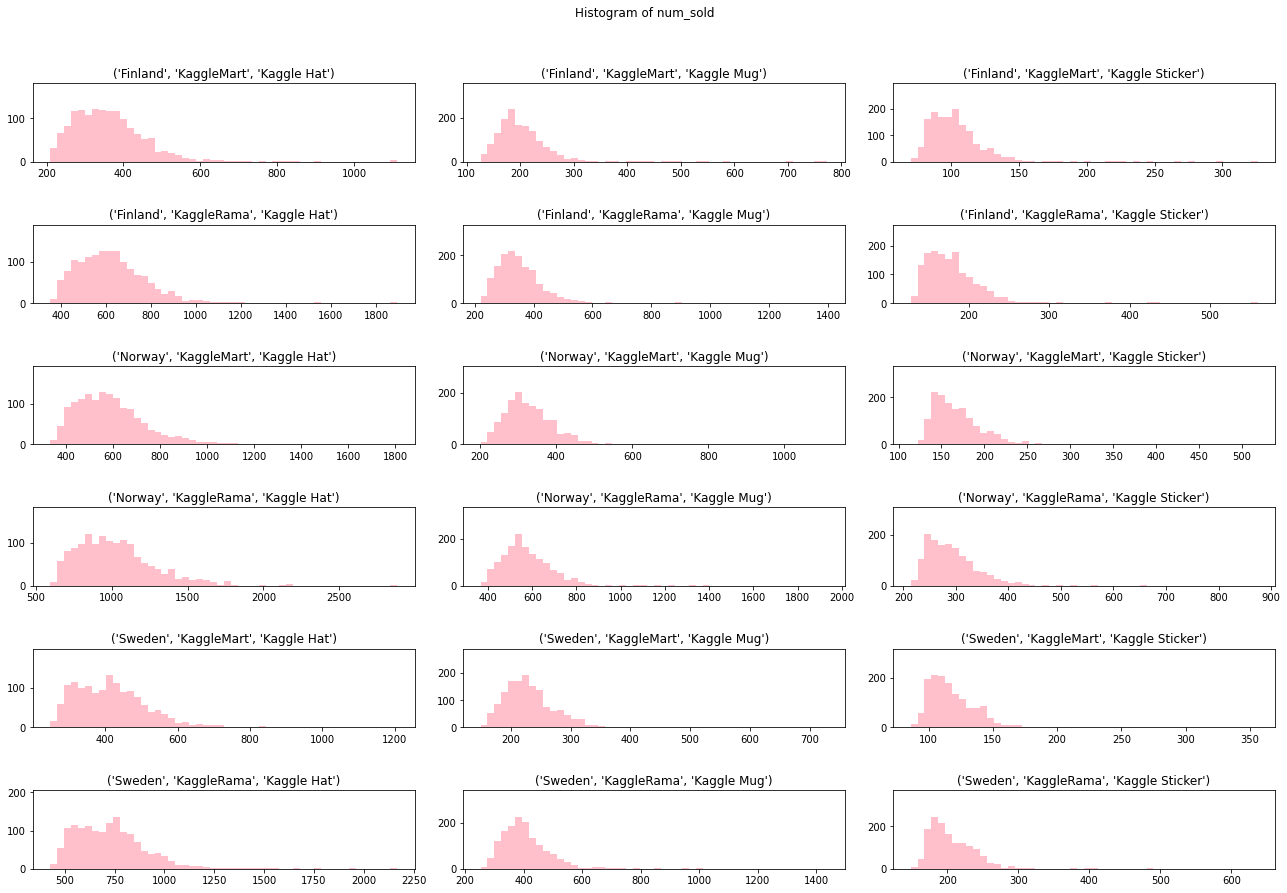

In [10]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    ax.hist(df.num_sold, bins=50, color='pink')
    ax.set_title(combi)
    
plt.suptitle("Histogram of num_sold", y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

# Time series
## Daily sales and the year-end peak
- 일별로 조합의 일별 num_sold를 보면 각 년도의 말기에 수치가 높아지는 것을 확인할 수 있다.
- 상품별로 그래프의 특징이 있는데 
    - Kaggle Hat은 겨울철에 판매량이 증가하는 경향을 보이고,
    - Mug는 Norway, Finland, Sweden 순으로 판매량이 많은 것을 보면 국가별 차이가 있는 것으로 보이고
    - Sticker는 대체로 그래프가 평탄하지만 Norway의 2분기에 매출량이 증가하는 것이 보인다.
    
### Insight
- model에 계절별 특징을 반영할 수 있어야 한다.
- 년 단위의 그래프 뿐만 아니라 짧은 spike 들도 반영해야 된다.

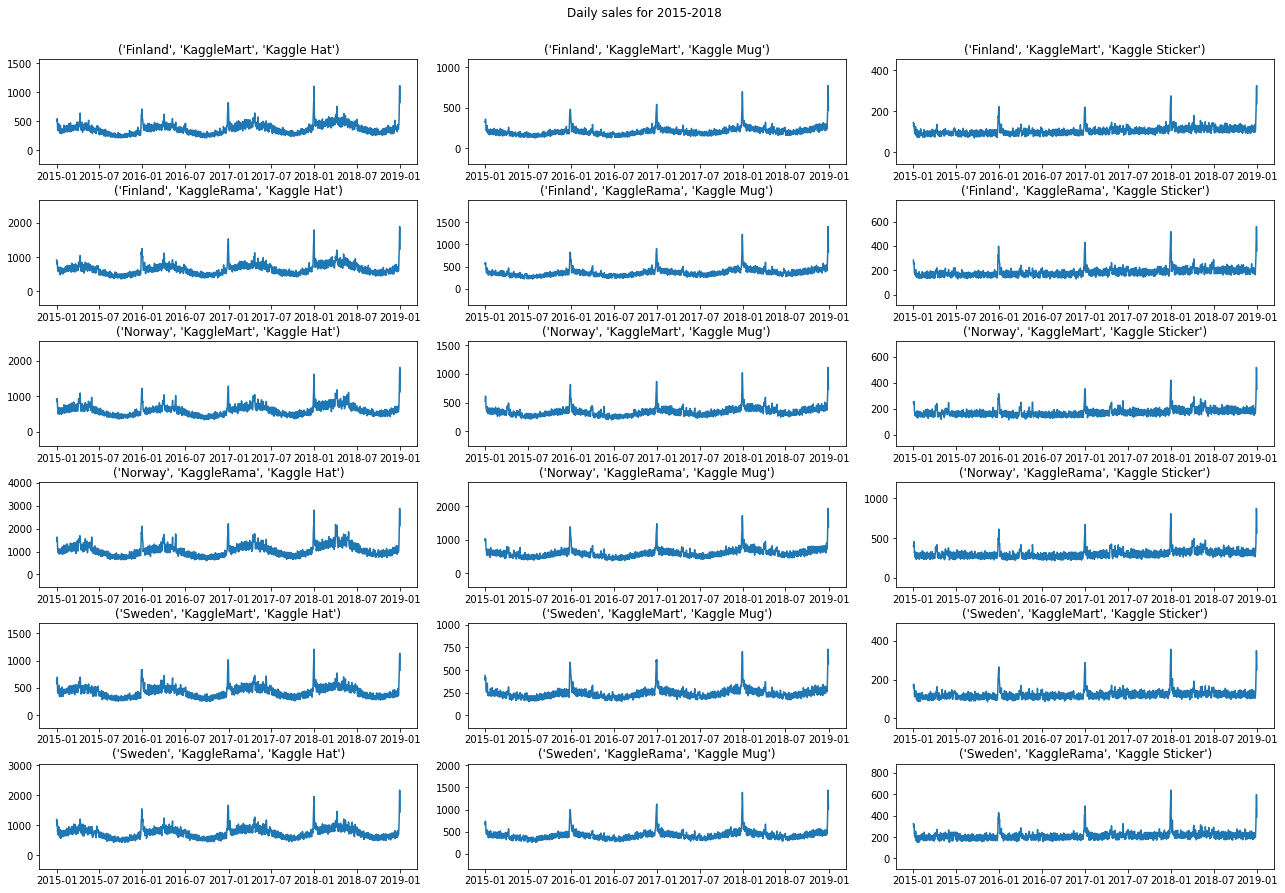

In [11]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    ax.plot(df.num_sold)
    ax.set_title(combi)
    
plt.tight_layout(h_pad=0.3)
plt.suptitle('Daily sales for 2015-2018', y=1.03)
plt.show()

- 4년간 매출량의 12월 평균을 내어 연말의 상황을 살펴보자
- 노란색 부분을 보면 크리스마스 이후에 매출량이 증가하는 것을 볼 수 있다.

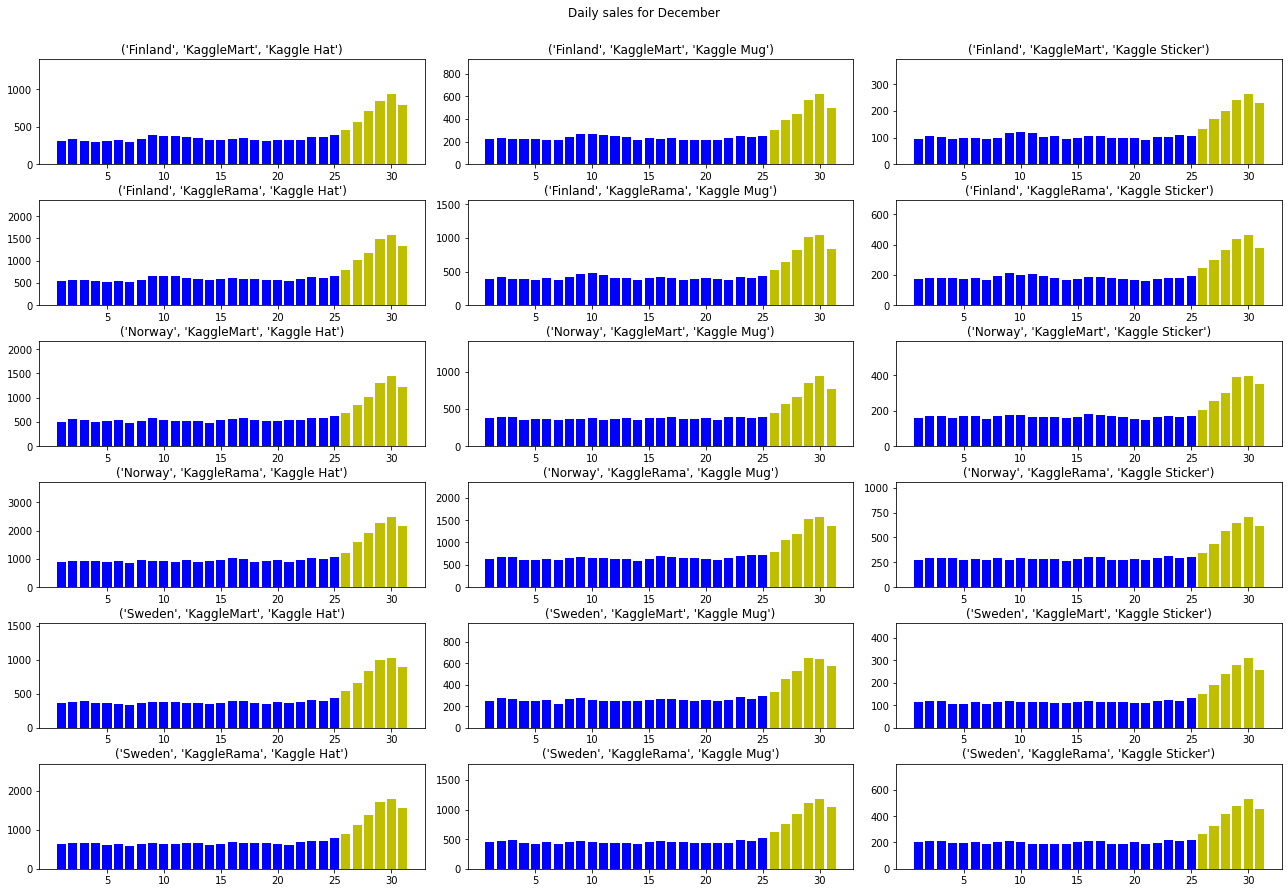

In [12]:
plt.figure(figsize=(18,12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    ax.bar(range(1, 32),
          df.num_sold[df.date.dt.month==12].groupby(df.date.dt.day).mean(),
          color=['b'] * 25 + ['y'] * 6)
    ax.set_title(combi)
    ax.set_xticks(ticks=range(5, 31, 5))

plt.tight_layout(h_pad=0.3)
plt.suptitle('Daily sales for December', y=1.03)
plt.show()
        

## Monthly sales and seasonal variation
- 월별로 매출량을 분석했을 때 계절별 변화와 성장 추세를 확인할 수 있다.
- Sticker가 hat에 비해 증가세가 뚜렷해 보인다.

### Insight
- 증가 추세를 통해 다음년도(2019)의 값을 예측할 수도 있다.

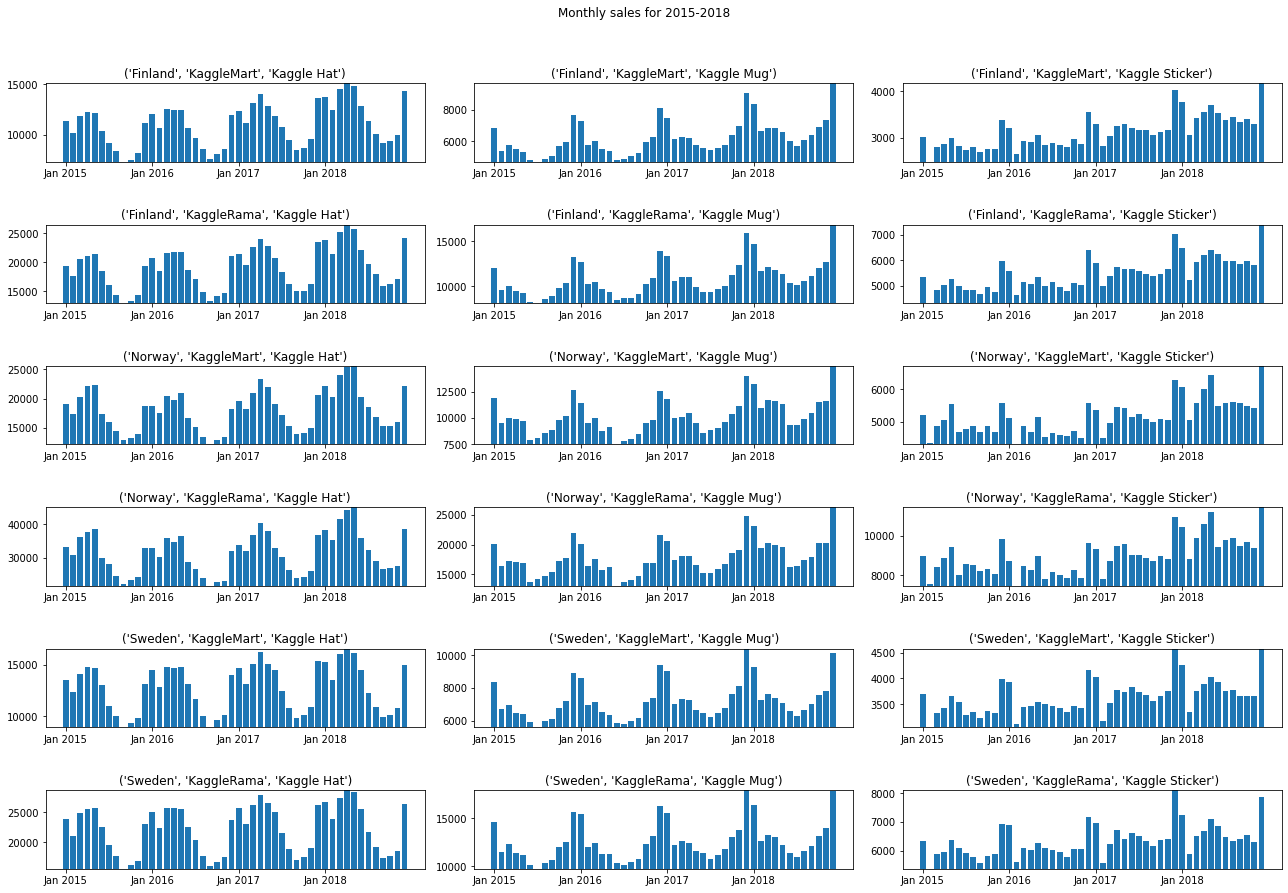

In [13]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    resampled = df.resample('MS').num_sold.sum()
    ax.bar(range(len(resampled)), resampled)
    ax.set_title(combi)
    ax.set_ylim(resampled.min(), resampled.max())
    ax.set_xticks(range(0, 48, 12), [f"Jan {y}" for y in range(2015, 2019)])
    
plt.suptitle('Monthly sales for 2015-2018', y = 1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

- Hat은 대체적으로 4,5 월에 최대치를 찍고 9월달에 최소치를 찍는다.
- Mug는 12월달에 최대치를 찍고, 6,7월달에 최소치를 찍는다.
- Sticker는 12,1월에 최대치를 찍고, 2월달에 최소치를 찍는다.(5월달에도 스파이크가 있다.)

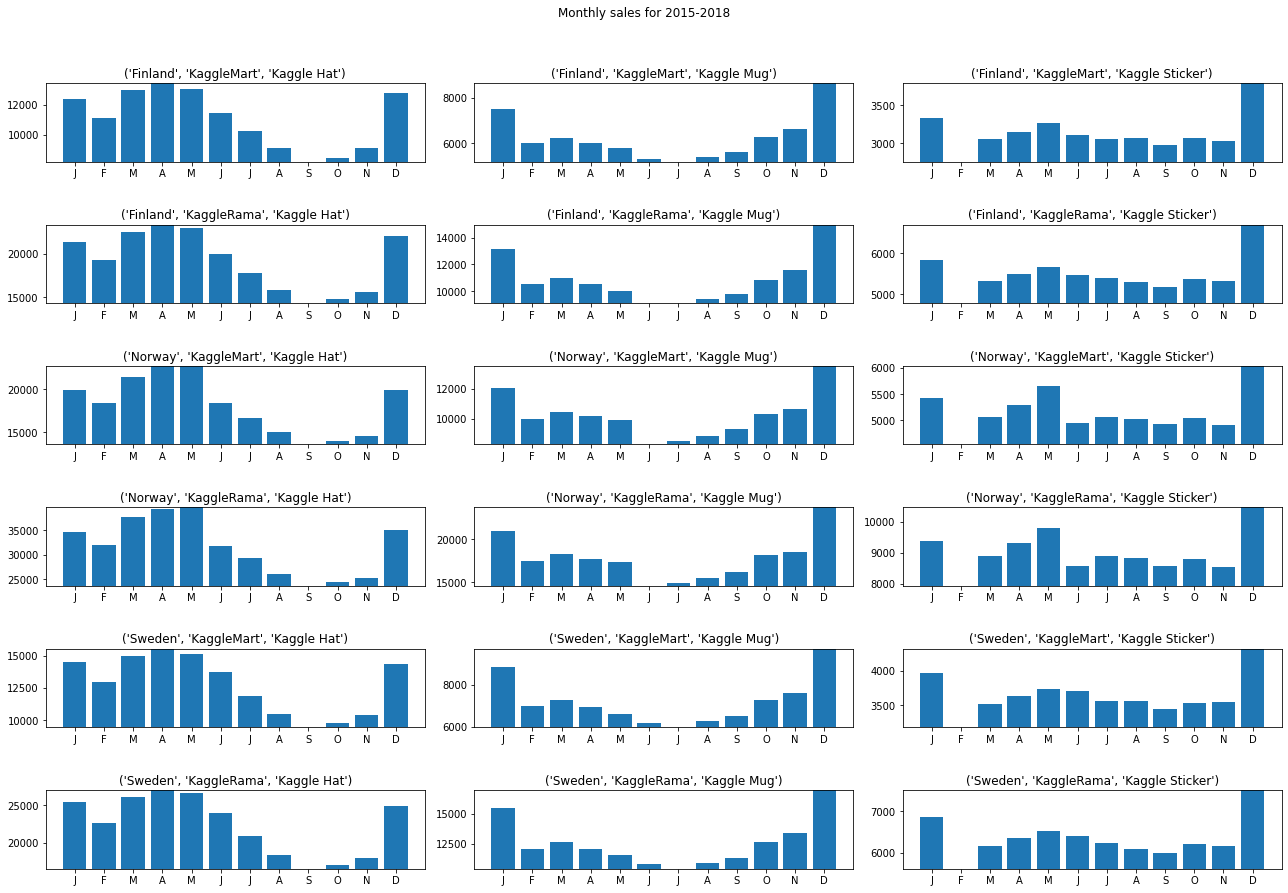

In [14]:
plt.figure(figsize=(18,12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    resampled = df.resample('MS').sum()
    resampled = resampled.groupby(resampled.index.month).mean()
    ax.bar(range(1, 13), resampled.num_sold)
    ax.set_xticks(ticks=range(1,13), labels='JFMAMJJASOND')
    ax.set_title(combi)
    ax.set_ylim(resampled.num_sold.min(), resampled.num_sold.max())

plt.suptitle('Monthly sales for 2015-2018', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()


## Growth
- 년도별로 매출량을 합하면 성장 추세를 확인할 수 있다.(계절별 변화 무시 가능)
    - Norway는 2016년에 살짝 마이너스 성장했다.
    - Sweden은 2018년 성장이 거의 없다.
    - 대체적으로 매년 성장한다.
    
### insight
- 국가별로 성장률을 모델링해야함
- 성장은 지수성장이나 선형 성장이 아니다.
- 연말에 매출이 몰리는 것을 감안해 다른 성장률도 모델링해야함

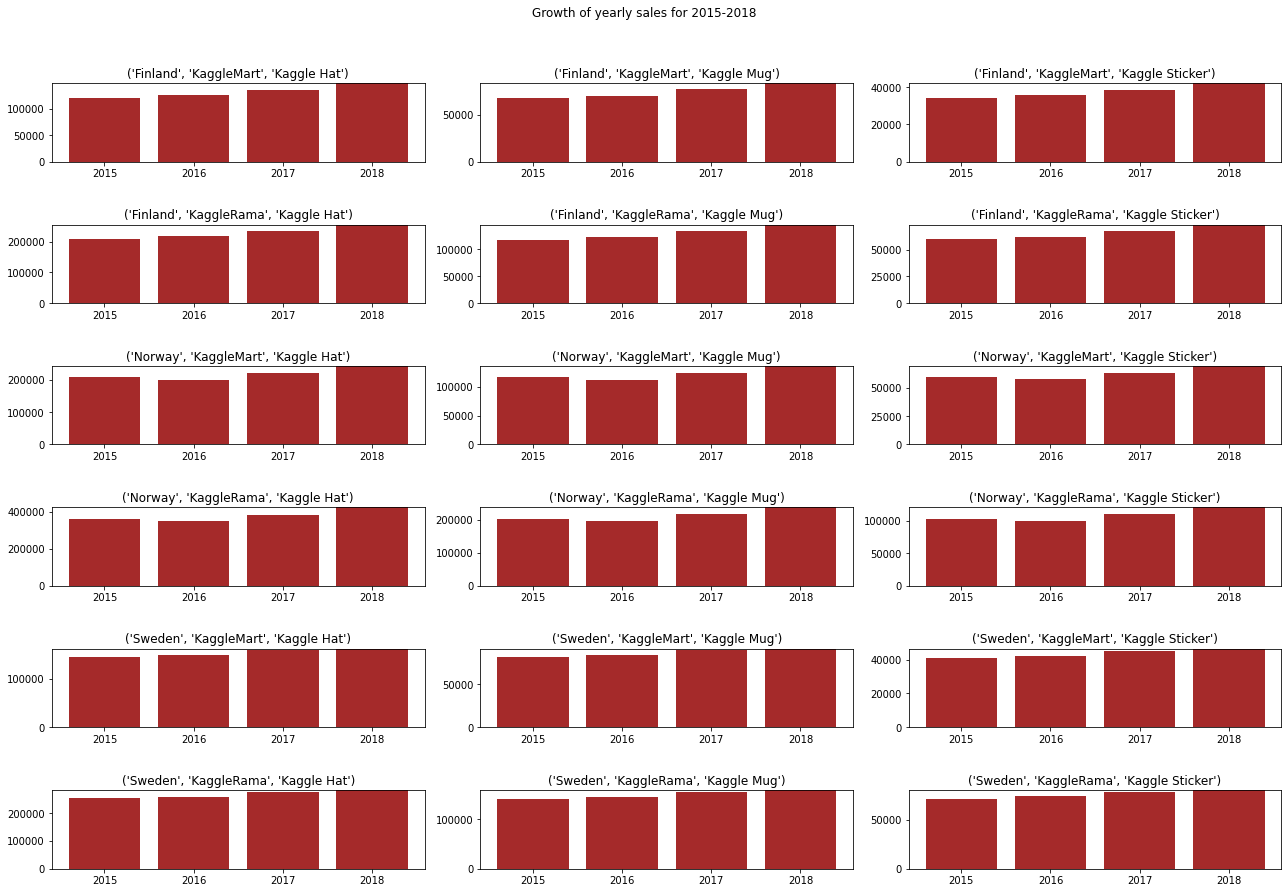

In [15]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    resampled = df.resample('AS').sum()
    ax.bar(range(2015, 2019), resampled.num_sold, color='brown')
    ax.set_title(combi)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(0, resampled.num_sold.max())
plt.suptitle('Growth of yearly sales for 2015-2018', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

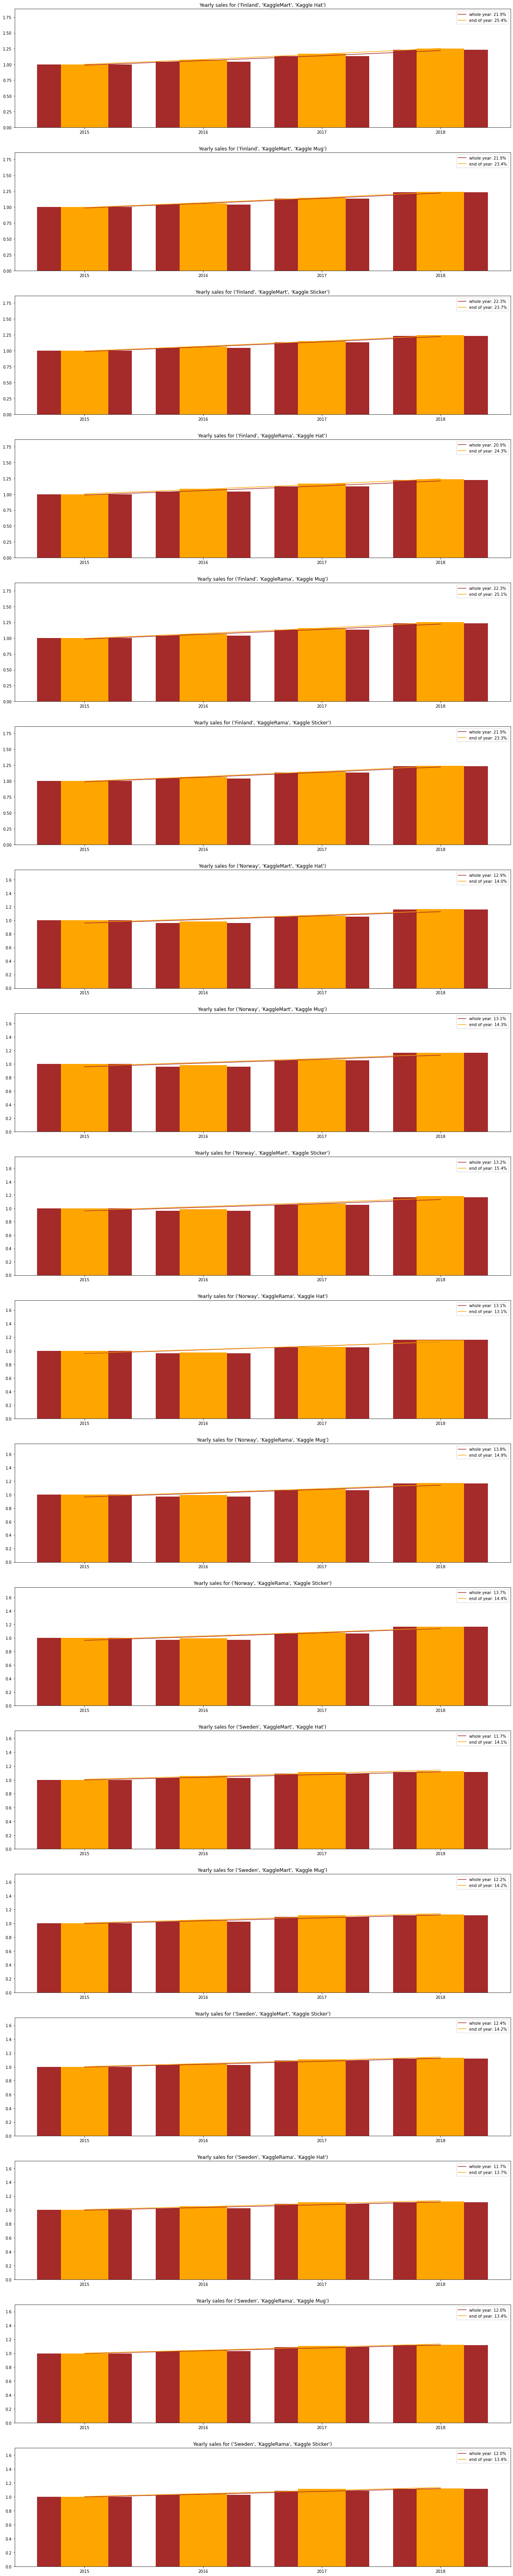

In [16]:
plt.figure(figsize=(18, 90))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(18, 1, i+1, ymargin=0.5)
    resampled = df[(df.date.dt.month<12) | (df.date.dt.day<25)].resample('AS').num_sold.sum()
    resampled /= resampled.iloc[0]
    resampled_end_of_year = df[(df.date.dt.month==12) | (df.date.dt.day>=25)].resample('AS').num_sold.sum()
    resampled_end_of_year /= resampled_end_of_year.iloc[0]
    ax.bar(range(2015, 2019), resampled, color='brown')
    ax.bar(range(2015, 2019), resampled_end_of_year, color='orange', width=0.4)
    
    X = np.arange(2015, 2019).reshape(-1, 1)
    lr = TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)
    lr.fit(X, resampled)
    ax.plot(range(2015, 2019), lr.predict(X), color='brown', label=f"whole year: {lr.predict([[2018]]).squeeze() - 1:.1%}")
    lr.fit(X, resampled_end_of_year)
    ax.plot(range(2015, 2019), lr.predict(X), color='orange', label = f"end of year: {lr.predict([[2018]]).squeeze() - 1:.1%}")
    
    ax.legend()
    ax.set_title(f"Yearly sales for {combi}")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout(h_pad=3.0)
plt.show()

## Weekdays
- 모든 상품에서 주말에 매출량이 제일 많다
- 주중에서도 금요일이 가장 매출량이 좋다.

### insight
- 우리의 모델은 적어도 월-목, 금, 토-일 을 구분이 되어야한다.

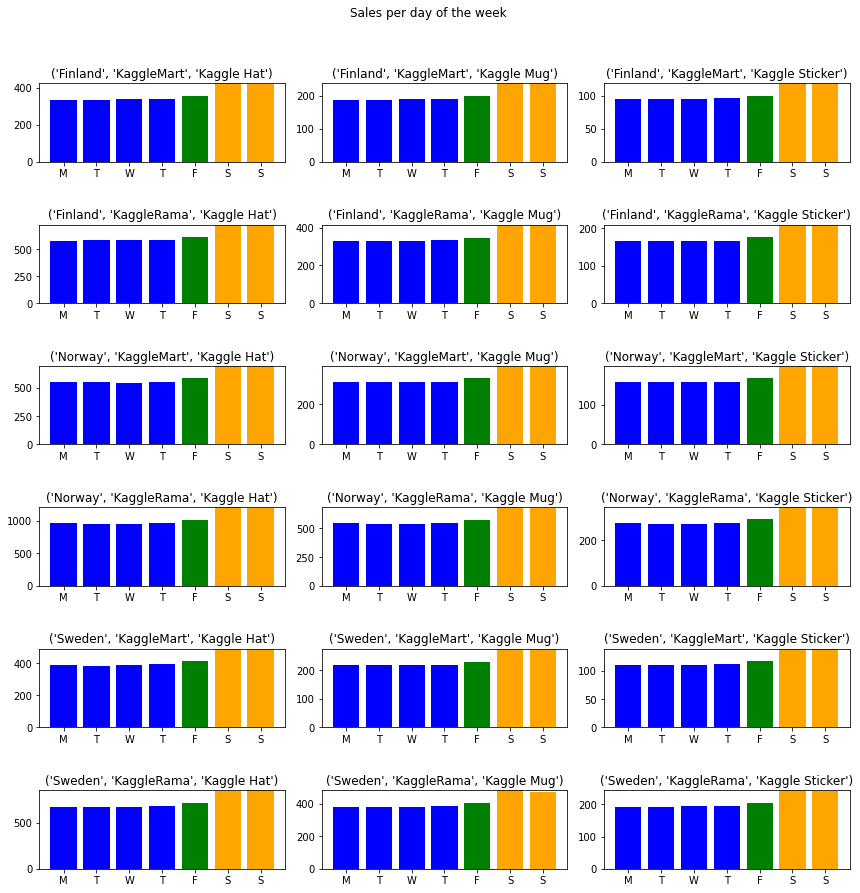

In [17]:
plt.figure(figsize=(12,12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    resampled = df.groupby(df.index.dayofweek).mean()
    ax.bar(range(7), resampled.num_sold,
           color = ['b'] * 4 + ['g'] + ['orange'] * 2)
    ax.set_title(combi)
    ax.set_xticks(ticks=range(7), labels=('M', 'T', 'W', 'T', 'F', 'S', 'S'))
    ax.set_ylim(0, resampled.num_sold.max())
plt.suptitle('Sales per day of the week', y= 1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

## Easter
- 부활절 이후의 매출량이 평소보다 높다.
- 

### insight
- 모델은 부활절의 날짜를 알아야하고 부활절 다음에 수요가 많음을 인식해야함

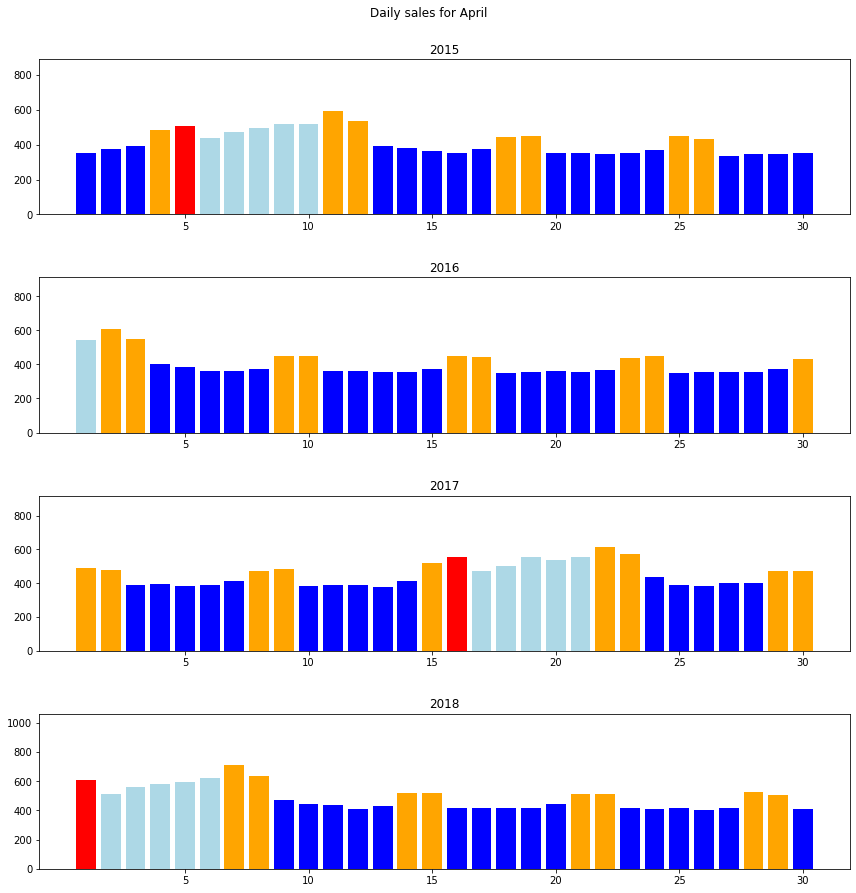

In [18]:
plt.figure(figsize=(12,12))
for i, (year, df) in enumerate(train_df.groupby(train_df.date.dt.year)):
    df = df.reset_index(drop=True)
    ax = plt.subplot(4, 1, i+1, ymargin=0.5)
    april = df.num_sold[(df.date.dt.month==4)].groupby(df.date.dt.day).mean()
    date_range = pd.date_range(start=f'{year}-04-01', end=f'{year}-04-30', freq='D')
    easter_date = easter.easter(year)
    color = ['r' if d == easter_date else 'lightblue' if (d.date() - easter_date).days in range(6) else 'b' if d.dayofweek < 5 else 'orange' for d in date_range]
    ax.bar(range(1,31),
          april,
          color=color)
    ax.set_title(str(year))
    ax.set_xticks(ticks=range(5, 31, 5))
plt.tight_layout(h_pad=3.0)
plt.suptitle('Daily sales for April', y=1.03)
plt.show()